In [23]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf
from scipy.signal import periodogram

plt.style.use("seaborn-v0_8")

# Load CSV
df = pd.read_csv("data2/dispersion_factors.csv", parse_dates=["date_ny"])
df = df.set_index("date_ny")

df.head()

,F1,F2,F3,F1_z60,F2_z60,F3_z60,Dispersion_Z_60d,Dispersion_Z_EWMA_20,Dispersion_Z_EWMA_30,Dispersion_Z_EWMA_60,Dispersion_Z_SMA_60,Dispersion_Z_SMA_90,Dispersion_Z_SMA_120
date_ny,,,,,,,,,,,,,
2020-06-01,0.162529,0.105292,0.712246,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-02,0.222298,0.114830,0.785626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-03,0.108393,0.121592,0.795996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-04,0.056167,0.103976,0.726426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-05,0.180939,0.133809,0.986852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ============================
# Cell 2: Seasonality helpers
# ============================

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from scipy.signal import periodogram, detrend
from statsmodels.graphics.tsaplots import plot_acf  # not strictly needed now, but OK to keep


def test_seasonality(series, name, period=252):
    """
    Run visual + numerical time-series seasonality diagnostics on a series.

    Methods:
      1) Seasonal decomposition (trend / seasonal / residual)
      2) ACF at seasonal lags (with lag 0 removed from plot)
      3) Spectral analysis (periodogram, freq 0 removed, detrended)

    Parameters
    ----------
    series : pd.Series
        Time series with a DatetimeIndex.
    name : str
        Name of the series (for titles/printing).
    period : int
        Seasonal period in observations (252 ~ 1 trading year).
    """
    print("\n" + "=" * 50)
    print(f" TIME-SERIES SEASONALITY TEST FOR: {name}")
    print("=" * 50 + "\n")

    s = series.dropna().copy()

    # ---------------------------------
    # 1) Seasonal decomposition
    # ---------------------------------
    print("1) Seasonal decomposition\n")

    try:
        result = seasonal_decompose(s, model="additive", period=period)

        # Plot decomposition
        fig = result.plot()
        fig.subplots_adjust(top=0.88)
        fig.suptitle(f"Seasonal Decomposition of {name}", fontsize=14)
        plt.show()

        # Numerical metrics from decomposition
        resid = result.resid.dropna()
        seas = result.seasonal.loc[resid.index]

        # Seasonal strength (Hyndman-style)
        seasonal_strength = 1 - (resid.var() / (resid.add(seas)).var())

        # Variance ratio: how much of total variance is seasonal
        seasonality_ratio = result.seasonal.var() / s.var()

    except Exception as e:
        print(f"Decomposition failed: {e}")
        seasonal_strength = np.nan
        seasonality_ratio = np.nan
        result = None

    # ---------------------------------
    # 2) ACF at seasonal lags (clean plot)
    # ---------------------------------
    print("\n2) Autocorrelation at seasonal lags\n")

    max_lag = min(len(s) - 1, period * 2)

    # compute acf so we can drop lag 0 from the plot
    lag_acf = acf(s, nlags=max_lag)
    lags = np.arange(len(lag_acf))

    plt.figure(figsize=(8, 5))
    # skip lag 0 in the plot to avoid the big spike
    plt.stem(lags[1:], lag_acf[1:])
    plt.xlabel("Lag (days)")
    plt.ylabel("ACF")
    plt.title(f"ACF for {name} (lag 0 removed)")
    # hide the very short lags visually if you want
    if max_lag > 10:
        plt.xlim(5, max_lag)
    plt.ylim(-0.5, 0.5)
    plt.axhline(0, color="black", linewidth=0.8)
    plt.show()

    # Numerical ACF metrics
    seasonal_lags = sorted({int(period / 12), int(period / 4), int(period / 2), period})
    seasonal_lags = [l for l in seasonal_lags if 0 < l < len(lag_acf)]

    if seasonal_lags:
        seasonal_acf_values = [lag_acf[l] for l in seasonal_lags]
        seasonal_acf_peak = float(np.max(np.abs(seasonal_acf_values)))
    else:
        seasonal_acf_values = []
        seasonal_acf_peak = np.nan

    # ---------------------------------
    # 3) Spectral analysis (periodogram, cleaned)
    # ---------------------------------
    print("\n3) Spectral analysis (periodogram)\n")

    # detrend to reduce low-frequency dominance
    s_detrended = detrend(s.values)
    freqs, power = periodogram(s_detrended)

    # drop the zero-frequency bin
    freqs, power = freqs[1:], power[1:]

    plt.figure(figsize=(8, 5))
    plt.semilogy(freqs, power)
    plt.title(f"Spectral Density (Periodogram) of {name} (freq 0 removed)")
    plt.xlabel("Frequency (cycles per day)")
    plt.ylabel("Power")

    # optional: zoom into band where seasonal cycles typically live
    # e.g. 1/252 ~ 0.004 (year), 1/63 ~ 0.016 (quarter), etc.
    plt.xlim(0.005, 0.05)
    plt.show()

    # Dominant frequency (now ignoring freq 0 already)
    if len(freqs) > 0:
        dom_idx = np.argmax(power)
        dom_freq = freqs[dom_idx]
        dom_period = 1.0 / dom_freq if dom_freq > 0 else np.nan
    else:
        dom_freq = np.nan
        dom_period = np.nan

    # ---------------------------------
    # 4) Print numerical summary
    # ---------------------------------
    print("Numerical time-series seasonality metrics:")
    print(f"  Seasonal strength (0–1)         : {seasonal_strength: .4f}")
    print(f"  Seasonality variance ratio      : {seasonality_ratio: .4f}")
    print(f"  Seasonal lags checked (ACF)     : {seasonal_lags}")
    if seasonal_lags:
        print(f"  Seasonal ACF values             : {[float(round(v, 4)) for v in seasonal_acf_values]}")
    print(f"  Seasonal ACF peak (|ρ|)         : {seasonal_acf_peak: .4f}")
    print(f"  Dominant frequency (periodogram): {dom_freq: .6f}")
    print(f"  Approx. dominant period (days)  : {dom_period: .2f}")

    # Quick interpretation hints
    print("\nHeuristic interpretation:")
    if seasonal_strength < 0.1:
        print("  → Seasonal strength: negligible.")
    elif seasonal_strength < 0.3:
        print("  → Seasonal strength: weak.")
    elif seasonal_strength < 0.6:
        print("  → Seasonal strength: moderate.")
    else:
        print("  → Seasonal strength: strong.")

    if seasonal_acf_peak < 0.1:
        print("  → ACF seasonal signal: very weak / none.")
    elif seasonal_acf_peak < 0.3:
        print("  → ACF seasonal signal: weak–moderate.")
    else:
        print("  → ACF seasonal signal: strong.")

    if not np.isnan(dom_period):
        print(f"  → Dominant period ~ {dom_period:.1f} days (if the periodogram shows a clear spike there).")


 TIME-SERIES SEASONALITY TEST FOR: Dispersion_Z_60d

1) Seasonal decomposition



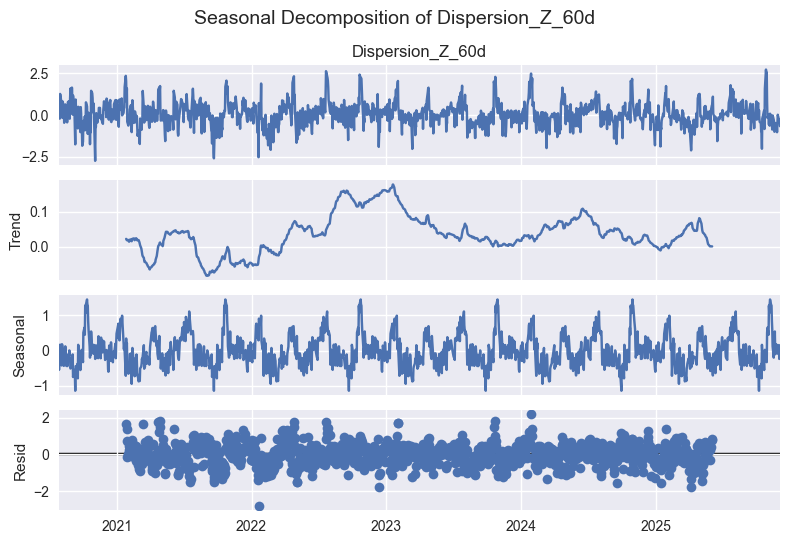


2) Autocorrelation at seasonal lags



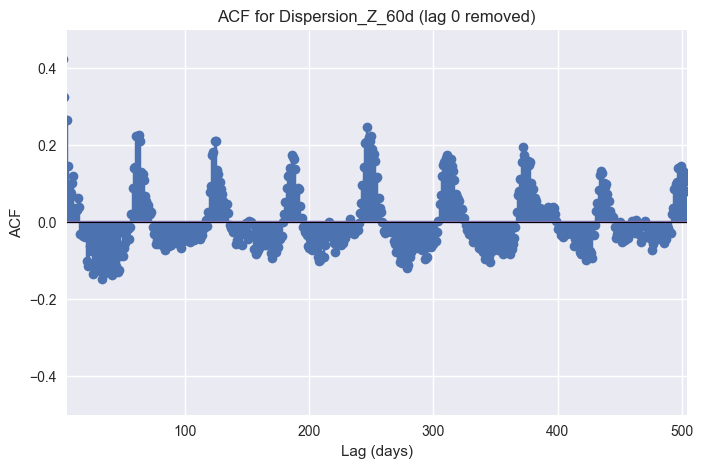


3) Spectral analysis (periodogram)



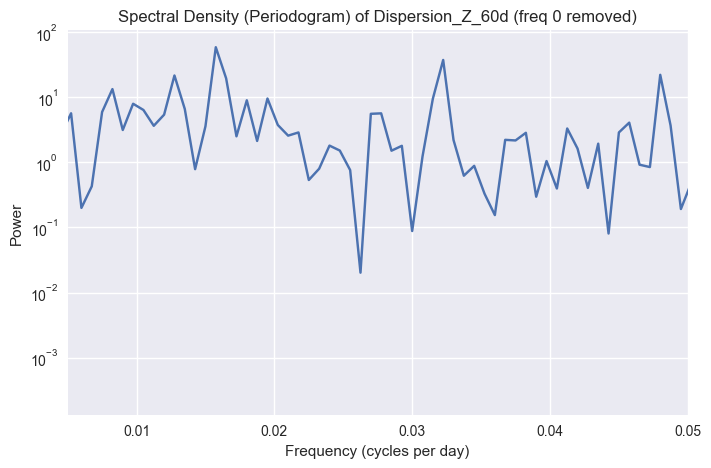

Numerical time-series seasonality metrics:
  Seasonal strength (0–1)         :  0.3752
  Seasonality variance ratio      :  0.3747
  Seasonal lags checked (ACF)     : [21, 63, 126, 252]
  Seasonal ACF values             : [-0.1008, 0.2253, 0.1355, 0.1767]
  Seasonal ACF peak (|ρ|)         :  0.2253
  Dominant frequency (periodogram):  0.015754
  Approx. dominant period (days)  :  63.48

Heuristic interpretation:
  → Seasonal strength: moderate.
  → ACF seasonal signal: weak–moderate.
  → Dominant period ~ 63.5 days (if the periodogram shows a clear spike there).


In [39]:
# Test Dispersion Index
test_seasonality(df["Dispersion_Z_60d"], "Dispersion_Z_60d")


 TIME-SERIES SEASONALITY TEST FOR: F2_z60

1) Seasonal decomposition



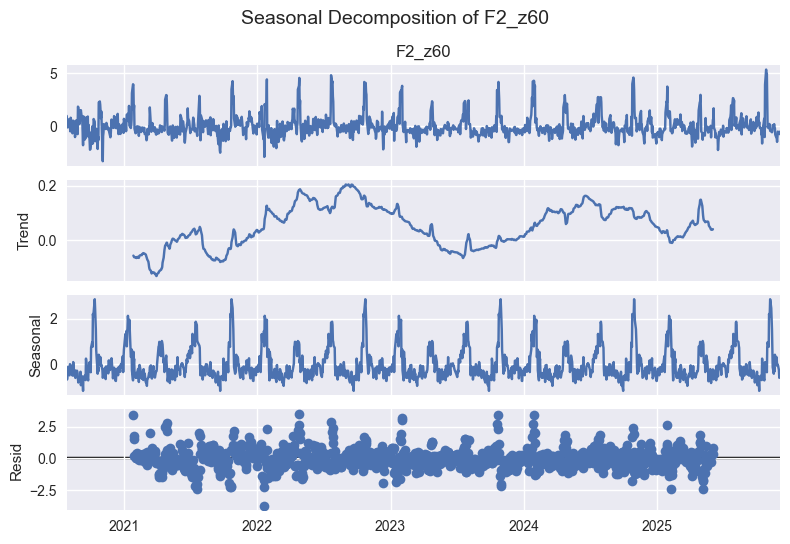


2) Autocorrelation at seasonal lags



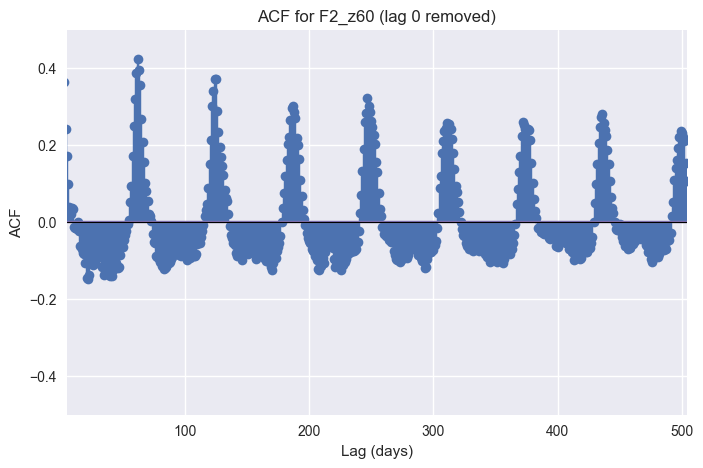


3) Spectral analysis (periodogram)



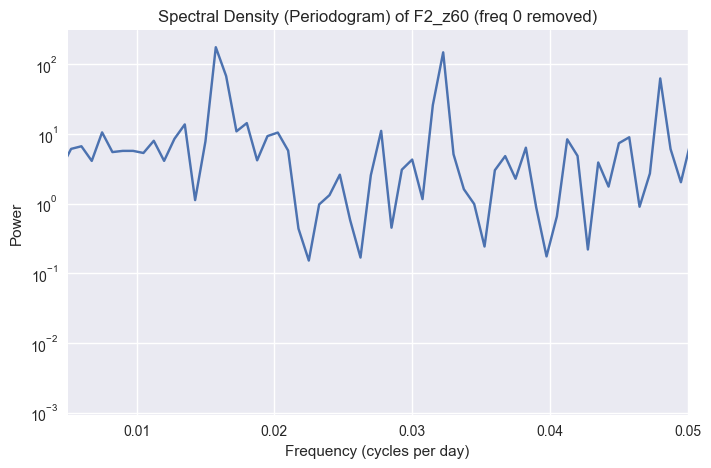

Numerical time-series seasonality metrics:
  Seasonal strength (0–1)         :  0.4206
  Seasonality variance ratio      :  0.4294
  Seasonal lags checked (ACF)     : [21, 63, 126, 252]
  Seasonal ACF values             : [-0.1457, 0.3944, 0.2892, 0.2255]
  Seasonal ACF peak (|ρ|)         :  0.3944
  Dominant frequency (periodogram):  0.015754
  Approx. dominant period (days)  :  63.48

Heuristic interpretation:
  → Seasonal strength: moderate.
  → ACF seasonal signal: strong.
  → Dominant period ~ 63.5 days (if the periodogram shows a clear spike there).


In [40]:
# Test F2_z60
test_seasonality(df["F2_z60"], "F2_z60")


 TIME-SERIES SEASONALITY TEST FOR: F3_z60

1) Seasonal decomposition



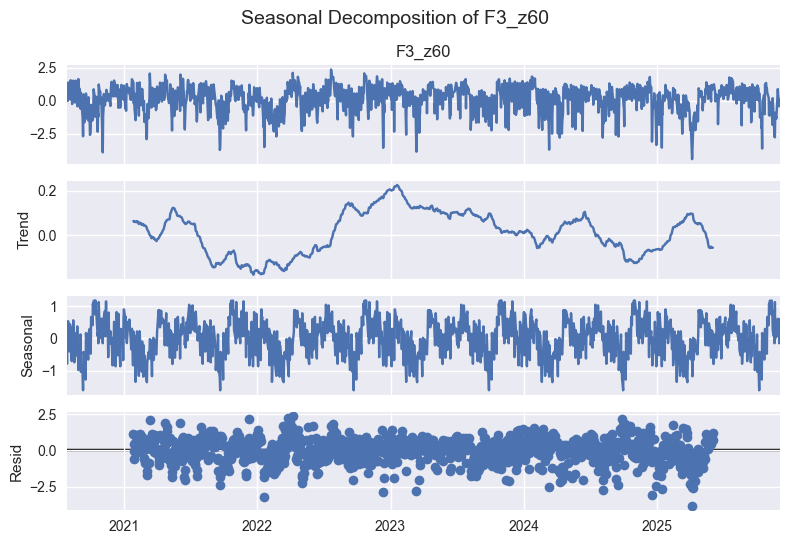


2) Autocorrelation at seasonal lags



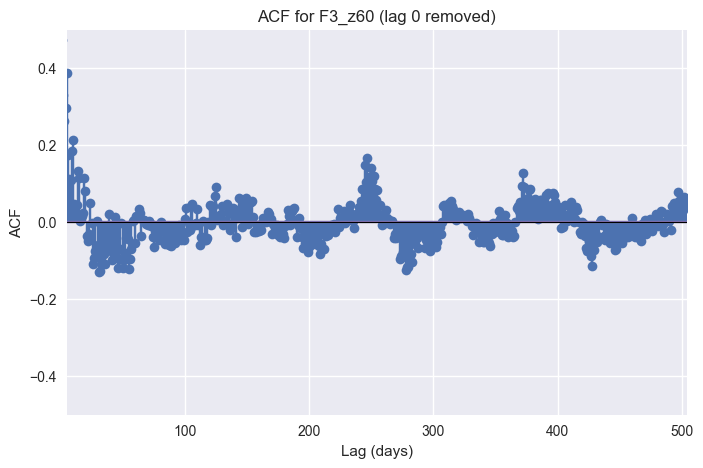


3) Spectral analysis (periodogram)



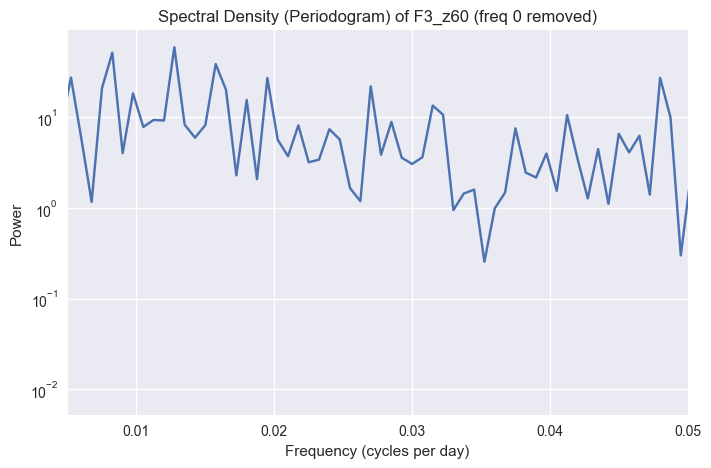

Numerical time-series seasonality metrics:
  Seasonal strength (0–1)         :  0.3053
  Seasonality variance ratio      :  0.3042
  Seasonal lags checked (ACF)     : [21, 63, 126, 252]
  Seasonal ACF values             : [-0.0362, 0.0335, 0.0053, 0.1197]
  Seasonal ACF peak (|ρ|)         :  0.1197
  Dominant frequency (periodogram):  0.012753
  Approx. dominant period (days)  :  78.41

Heuristic interpretation:
  → Seasonal strength: moderate.
  → ACF seasonal signal: weak–moderate.
  → Dominant period ~ 78.4 days (if the periodogram shows a clear spike there).


In [41]:
# Test F3_z60
test_seasonality(df["F3_z60"], "F3_z60")